Updated: 13/12/2023

This workbook demonstrates the spatial reconstruction of one linear mode, one quadratic mode and multiple modes simultaneously. 

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfitsrd as qnmfits
from multiprocessing import Pool
from spatial_reconstruction import *
from matplotlib.animation import FuncAnimation
from scipy.interpolate import UnivariateSpline

l_max = 6
n_max = 6
t0 = {0:40., 1:18.5, 2:12., 3:8., 4:5.5, 5:3., 6:1.5, 7:0.}[n_max]

In [96]:
# TO DO: import data properly 

sim = qnmfits.SXS(ID=305, zero_time=(2,2))

Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


In [93]:
mapping = [(2,2,0,1)]

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)]

best_fit_linear = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                        sim.h, 
                                        modes=QNMs.copy(),
                                        Mf=sim.Mf,
                                        chif=sim.chif_mag,
                                        t0=t0,
                                        mapping_modes=mapping,
                                        spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                               for m in np.arange(-l,l+1)])

[(2, -2, 0, -1), (2, -2, 0, 1), (2, -2, 1, -1), (2, -2, 1, 1), (2, -2, 2, -1), (2, -2, 2, 1), (2, -2, 3, -1), (2, -2, 3, 1), (2, -2, 4, -1), (2, -2, 4, 1), (2, -1, 0, -1), (2, -1, 0, 1), (2, -1, 1, -1), (2, -1, 1, 1), (2, -1, 2, -1), (2, -1, 2, 1), (2, -1, 3, -1), (2, -1, 3, 1), (2, -1, 4, -1), (2, -1, 4, 1), (2, 0, 0, -1), (2, 0, 0, 1), (2, 0, 1, -1), (2, 0, 1, 1), (2, 0, 2, -1), (2, 0, 2, 1), (2, 0, 3, -1), (2, 0, 3, 1), (2, 0, 4, -1), (2, 0, 4, 1), (2, 1, 0, -1), (2, 1, 0, 1), (2, 1, 1, -1), (2, 1, 1, 1), (2, 1, 2, -1), (2, 1, 2, 1), (2, 1, 3, -1), (2, 1, 3, 1), (2, 1, 4, -1), (2, 1, 4, 1), (2, 2, 0, -1), (2, 2, 1, -1), (2, 2, 1, 1), (2, 2, 2, -1), (2, 2, 2, 1), (2, 2, 3, -1), (2, 2, 3, 1), (2, 2, 4, -1), (2, 2, 4, 1), (3, -3, 0, -1), (3, -3, 0, 1), (3, -3, 1, -1), (3, -3, 1, 1), (3, -3, 2, -1), (3, -3, 2, 1), (3, -3, 3, -1), (3, -3, 3, 1), (3, -3, 4, -1), (3, -3, 4, 1), (3, -2, 0, -1), (3, -2, 0, 1), (3, -2, 1, -1), (3, -2, 1, 1), (3, -2, 2, -1), (3, -2, 2, 1), (3, -2, 3, -1), (3, 

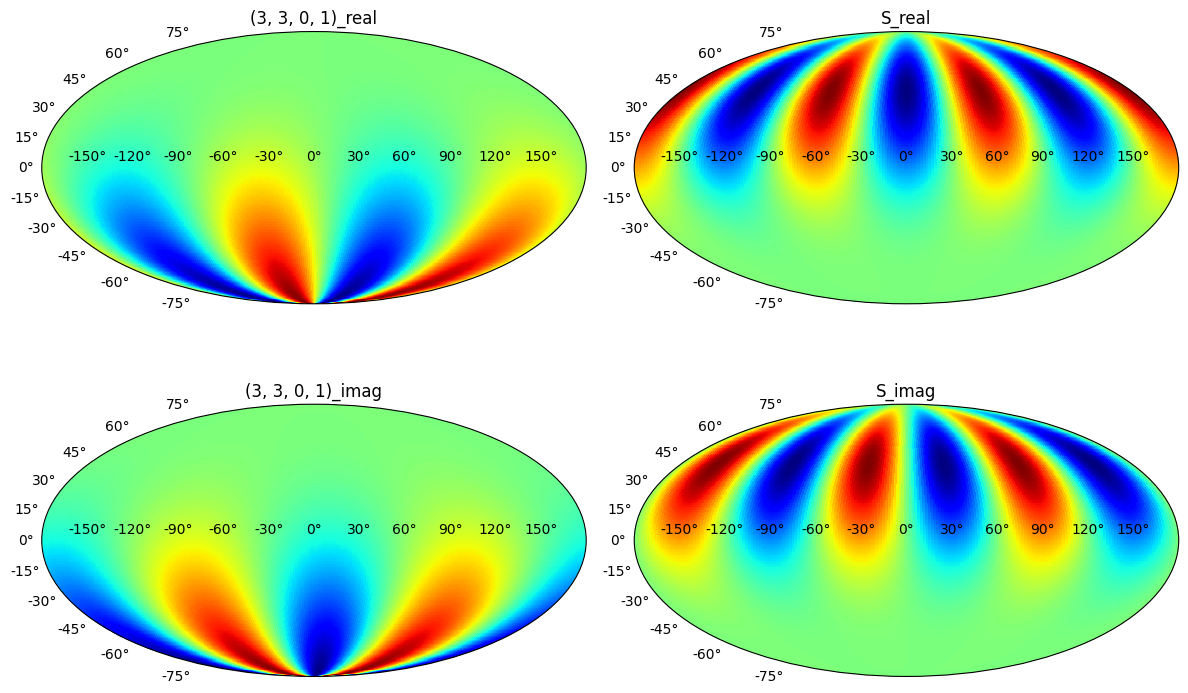

In [90]:
fig, axs = plt.subplots(nrows=2, ncols=2, 
                        subplot_kw={'projection': 'mollweide'}, 
                        figsize=(12,8))

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)

map = (3,3,0,1)

Lon, Lat = np.meshgrid(lon, lat)
F = mode_mapping(np.pi/2-Lat, Lon, best_fit_linear, map, l_max)
G = spheroidal(np.pi/2-Lat, Lon, map, l_max, sim.chif_mag)

axs[0,0].title.set_text(str(map)+'_real')
axs[0,0].pcolormesh(Lon, Lat, np.real(F), cmap=plt.cm.jet)

axs[1,0].title.set_text(str(map)+'_imag')
axs[1,0].pcolormesh(Lon, Lat, np.imag(F), cmap=plt.cm.jet)

axs[0,1].title.set_text('S_real')
axs[0,1].pcolormesh(Lon, Lat, np.real(G), cmap=plt.cm.jet)

axs[1,1].title.set_text('S_imag')
axs[1,1].pcolormesh(Lon, Lat, np.imag(G), cmap=plt.cm.jet)

plt.tight_layout()
plt.show()

## Calculate spatial mismatch over time

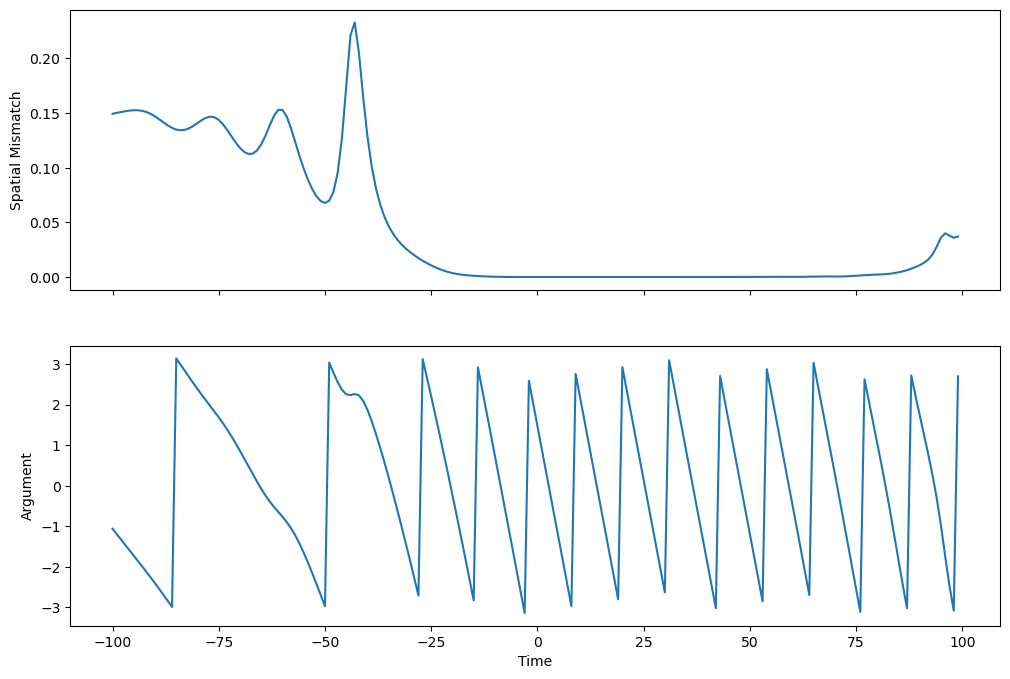

In [6]:
G = spheroidal(np.pi/2-Lat, Lon, map, l_max, sim.chif_mag)

time_array = np.arange(-100, 100, 1)
sm_list = []
arg_list = []

for time in time_array:
   best_fit = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                             sim.h, 
                                             modes=QNMs.copy(),
                                             Mf=sim.Mf,
                                             chif=sim.chif_mag,
                                             t0=time,
                                             mapping_modes=mapping,
                                             spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                               for m in np.arange(-l,l+1)])

   F = mode_mapping(np.pi/2-Lat, Lon, best_fit, map, l_max)

   sm, arg, _ = spatial_mismatch(F, G, num_points=100)
   sm_list.append(sm)
   arg_list.append(arg)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=True)
axs[0].plot(time_array, sm_list)
axs[1].plot(time_array, arg_list)

axs[0].set_ylabel('Spatial Mismatch')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Argument') 

plt.show()


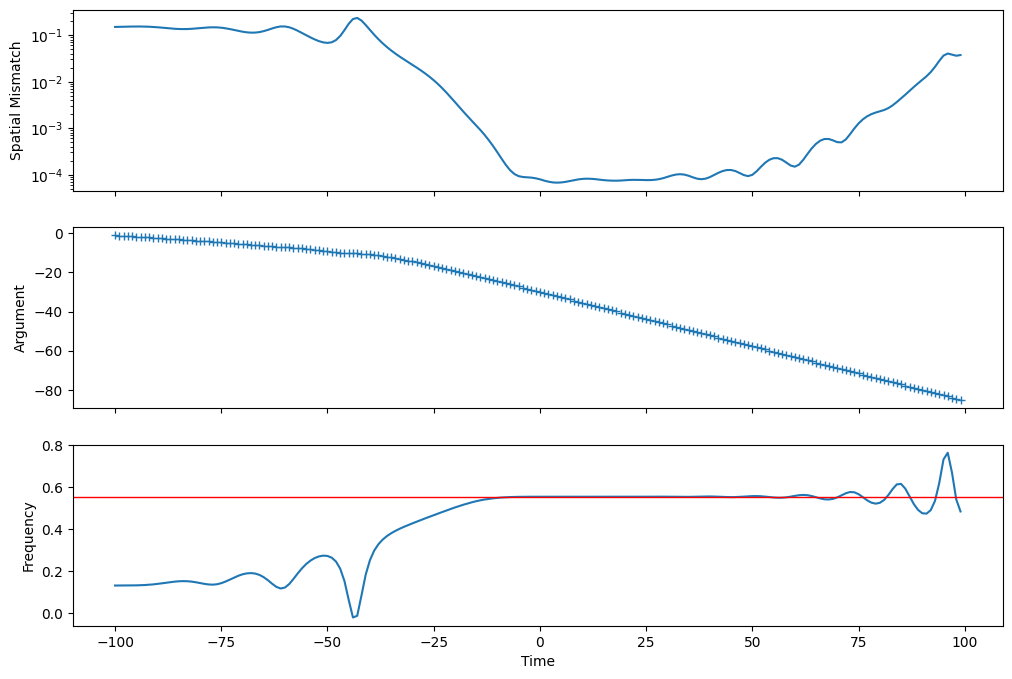

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12,8), sharex=True)
axs[0].plot(time_array, sm_list)
axs[1].plot(time_array, np.unwrap(arg_list), '+')

angle_v_time = UnivariateSpline(time_array, -np.unwrap(arg_list), k=4, s=0)
axs[2].plot(time_array, angle_v_time.derivative()(time_array))
axs[2].axhline(qnmfits.qnm.omega(2,2,0,1,sim.chif_mag, Mf=sim.Mf).real, color='r', ls='-', lw=1)

axs[0].set_yscale('log')
axs[0].set_ylabel('Spatial Mismatch')
axs[2].set_xlabel('Time')
axs[1].set_ylabel('Argument') 
axs[2].set_ylabel('Frequency') 

plt.show()

In [26]:
import numpy as np 

arg_list = [1,2,3,4,5,6,7,8,9,10,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]

diff_arg = np.diff(arg_list)

# Quadratic Test

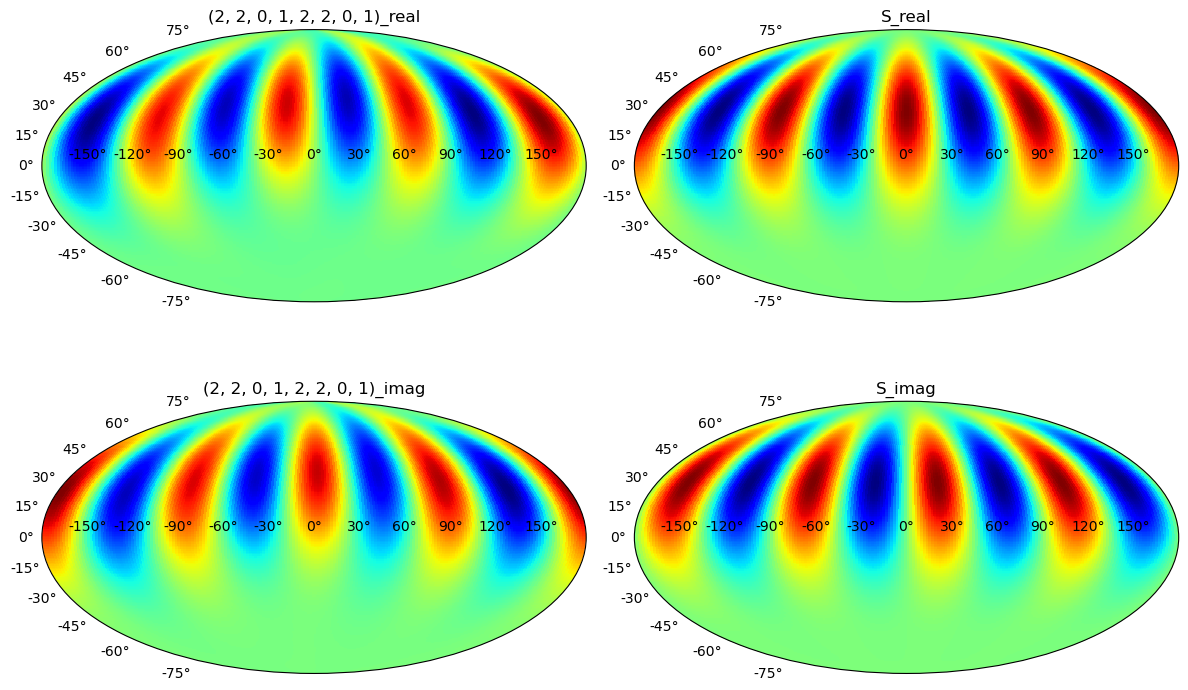

In [30]:
mapping = [(2,2,0,1,2,2,0,1)]

l_max = 4
n_max = 7

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)] + mapping 

best_fit_quad = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                        sim.h, 
                                        modes=QNMs.copy(),
                                        Mf=sim.Mf,
                                        chif=sim.chif_mag,
                                        t0=t0,
                                        mapping_modes=mapping,
                                        spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                               for m in np.arange(-l,l+1)])

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)
Lon, Lat = np.meshgrid(lon, lat)

#md_mapping = mode_mapping(np.pi/2-Lat, Lon, best_fit_quad, mapping[0], l_max)
#expected = spheroidal(np.pi/2-Lat, Lon, mapping[0], l_max, sim.chif_mag)

#qnm_viz.plot_mapping_projection(mapping[0], md_mapping, expected)

fig, axs = plt.subplots(nrows=2, ncols=2, 
                        subplot_kw={'projection': 'mollweide'}, 
                        figsize=(12,8))

Lon, Lat = np.meshgrid(lon, lat)
F = mode_mapping(np.pi/2-Lat, Lon, best_fit_quad, mapping[0], l_max)
G = spheroidal(np.pi/2-Lat, Lon, mapping[0], l_max, sim.chif_mag)

axs[0,0].title.set_text(str(mapping[0])+'_real')
axs[0,0].pcolormesh(Lon, Lat, np.real(F), cmap=plt.cm.jet)

axs[1,0].title.set_text(str(mapping[0])+'_imag')
axs[1,0].pcolormesh(Lon, Lat, np.imag(F), cmap=plt.cm.jet)

axs[0,1].title.set_text('S_real')
axs[0,1].pcolormesh(Lon, Lat, np.real(G), cmap=plt.cm.jet)

axs[1,1].title.set_text('S_imag')
axs[1,1].pcolormesh(Lon, Lat, np.imag(G), cmap=plt.cm.jet)

plt.tight_layout()
plt.show()

#### Spatial reconstruction of multiple modes

In [31]:
mapping = [(2,2,0,1), (3,3,0,1)] 

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)] 
                                                            
best_fit_multi = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                        sim.h, 
                                        modes=QNMs.copy(),
                                        Mf=sim.Mf,
                                        chif=sim.chif_mag,
                                        t0=t0,
                                        mapping_modes=mapping,
                                        spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                               for m in np.arange(-l,l+1)])

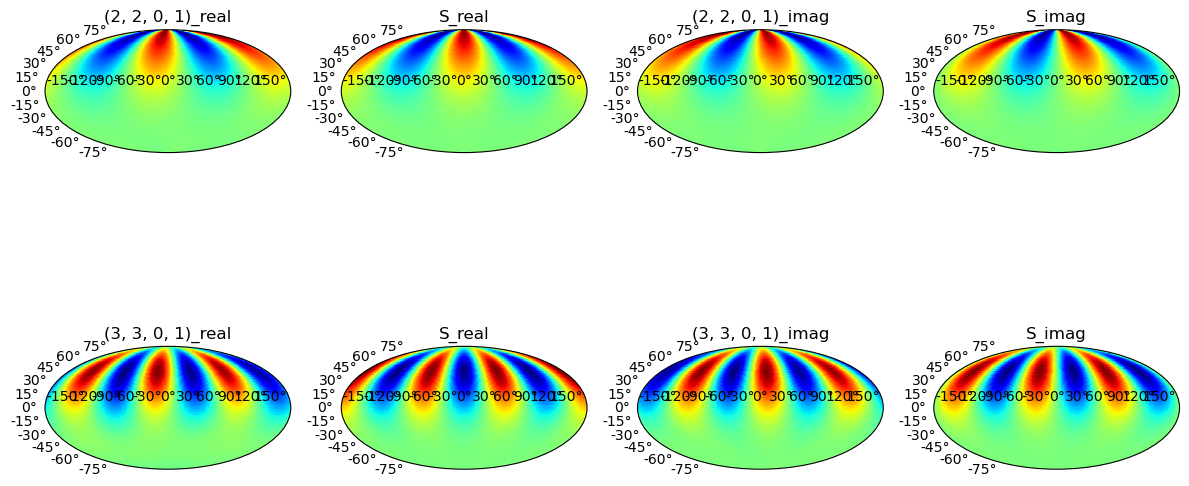

In [32]:

if len(mapping) == 1:
   nrows = 2
else:
   nrows = len(mapping)

fig, axs = plt.subplots(nrows=nrows, ncols=4, 
                  subplot_kw={'projection': 'mollweide'}, 
                  figsize=(12,8))

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)

Lon, Lat = np.meshgrid(lon, lat)

for i, mode in enumerate(mapping):
   F = mode_mapping(np.pi/2-Lat, Lon, best_fit_multi, mode, l_max)
   G = spheroidal(np.pi/2-Lat, Lon, mode, l_max, sim.chif_mag)

   axs[i, 0].title.set_text(str(mode)+'_real')
   axs[i, 0].pcolormesh(Lon, Lat, np.real(F), cmap=plt.cm.jet)

   axs[i, 1].title.set_text('S_real')
   axs[i, 1].pcolormesh(Lon, Lat, np.real(G), cmap=plt.cm.jet)

   axs[i, 2].title.set_text(str(mode)+'_imag')
   axs[i, 2].pcolormesh(Lon, Lat, np.imag(F), cmap=plt.cm.jet)

   axs[i, 3].title.set_text('S_imag')
   axs[i, 3].pcolormesh(Lon, Lat, np.imag(G), cmap=plt.cm.jet)

plt.tight_layout()
plt.show()

In [106]:
l_max = 5
n_max = 5

"""
mapping = [(5,5,0,1)] 
"""

mapping = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                           for mu in np.arange(-lam, lam+1)
                              for n in np.arange(0, n_max+1)
                                 for p in (-1, +1)] 

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)]


best_fit_overall = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                        sim.h, 
                                        modes=QNMs.copy(),
                                        Mf=sim.Mf,
                                        chif=sim.chif_mag,
                                        t0=t0,
                                        mapping_modes=mapping,
                                        spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                               for m in np.arange(-l,l+1)])


print(best_fit_overall[best_fit_overall['mapping'] == (5,5,0,1)])



[ 6.83414490e-01-5.09686485e-01j -2.07327196e-05+3.50664478e-05j
  3.26220272e-01+2.80353024e+00j  3.36556767e-03+2.21090463e-04j
 -3.84861518e+00-5.07349259e+00j -3.31130109e-02-3.99122083e-02j
  9.72850511e+00+7.84131532e+00j -6.14809221e-01+4.69897470e-03j
 -1.54188243e+01-7.11871252e+00j -8.52713516e-01+2.07712602e+00j
  9.09016083e+00+1.76345912e-01j  1.15065254e+00+1.77674808e-01j
  3.38516823e-02-3.12612535e-02j  5.06252914e-04+5.62937302e-04j
  2.47916696e-02+1.76587029e-01j -2.95154481e-02-2.66219931e-02j
 -2.20540926e-01+4.95133260e-01j  3.35797095e-01+8.37402606e-01j
 -4.09260130e+00-4.68564995e+00j  3.85136218e+00-5.69448008e+00j
  1.68430693e+01-1.74330558e+00j -1.24874711e+01-4.54433862e+00j
 -4.20879296e+00+1.04060565e+01j -9.55736544e-02+4.92834358e+00j
  1.66088766e-02-4.12640998e-03j  1.66482572e-02+4.12368830e-03j
 -1.37458226e-01-2.66517454e-02j -1.41374907e-01+2.89020923e-02j
  3.66177007e+00+5.13495207e-01j  3.77344777e+00-5.96155626e-01j
 -2.28292539e+01+1.893949

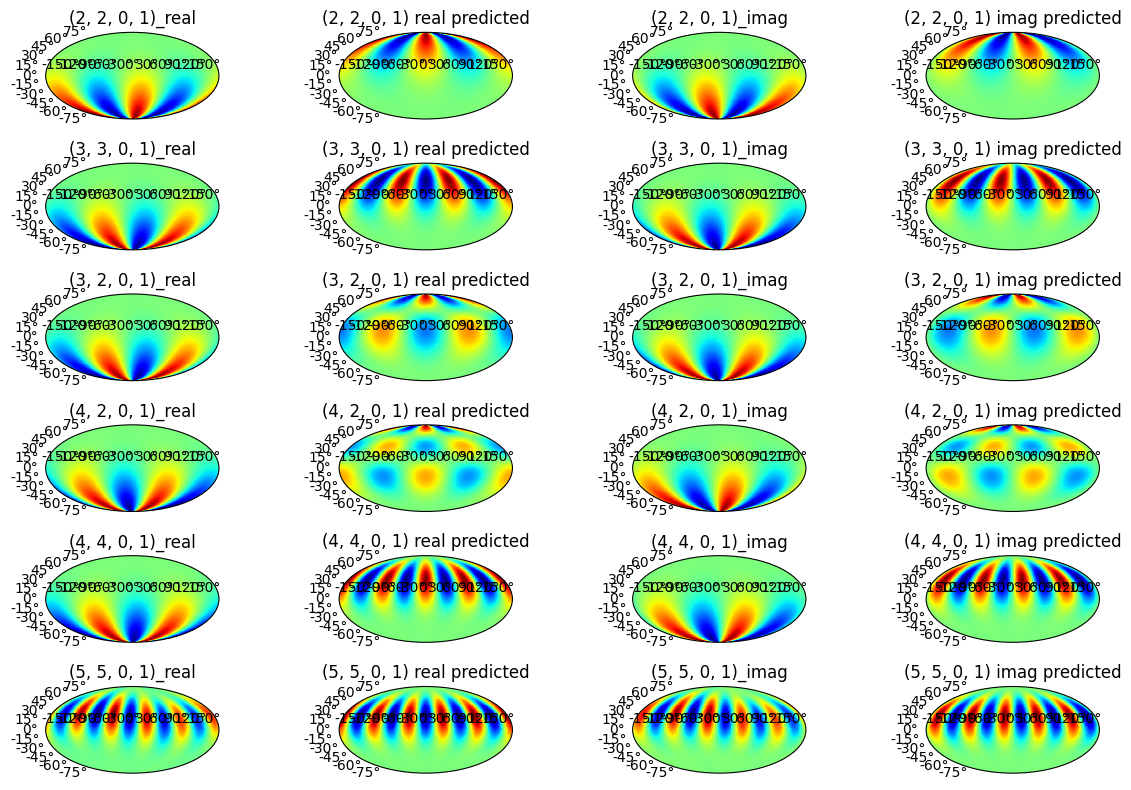

In [105]:
mapping_choice = [(2,2,0,1),(3,3,0,1),(3,2,0,1),(4,2,0,1),(4,4,0,1),(5,5,0,1)] 

fig, axs = plt.subplots(nrows=(len(mapping_choice)), ncols=4, 
                  subplot_kw={'projection': 'mollweide'}, 
                  figsize=(12,8))

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)

Lon, Lat = np.meshgrid(lon, lat)

for i, mode in enumerate(mapping_choice):
   F = mode_mapping(np.pi/2-Lat, Lon, best_fit_overall, mode, l_max)
   G = spheroidal(np.pi/2-Lat, Lon, mode, l_max, sim.chif_mag)

   axs[i, 0].title.set_text(str(mode)+'_real')
   axs[i, 0].pcolormesh(Lon, Lat, np.real(F), cmap=plt.cm.jet)

   axs[i, 1].title.set_text(str(mode)+' real predicted')
   axs[i, 1].pcolormesh(Lon, Lat, np.real(G), cmap=plt.cm.jet)

   axs[i, 2].title.set_text(str(mode)+'_imag')
   axs[i, 2].pcolormesh(Lon, Lat, np.imag(F), cmap=plt.cm.jet)

   axs[i, 3].title.set_text(str(mode)+' imag predicted')
   axs[i, 3].pcolormesh(Lon, Lat, np.imag(G), cmap=plt.cm.jet)

plt.tight_layout()
plt.show()